<a href="https://colab.research.google.com/github/SquaredR98/Deep-Learning-7th-Semester/blob/master/cnn_grad_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DL Assignment 2 
Implement a cnn model having 2 convolusion block, each convolusion block consists of convolusion layer which is followed by a relu function and then downsampled using max pooling. The 2nd conv block is then followed by 2 fully connected layers. We need to draw a scatter plot of gradient norm vs epoch.

Import the required libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.7.0+cu101


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Download the data and then normalize it so that we get a distribution with a mean of 0.1307 and a standard deviation of 0.3081.

In [ ]:
train_set = dataset.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

test_set = dataset.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# initialising batch size for training and testing
bs = 100

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = bs, shuffle=True)

To calculate the output dimension, we will use formula : `W_out = ((W_in - F + 2P)/S) + 1`

where 
W : width,
S : number of stride,
F = filter size (or kernel size)

`1st Layer = Conv1 (using 5 * 5 kernel) + Relu + MaxPooling (using 2 * 2 kernel)`
>The output of 1st layer is 14 * 14 * 32 i.e., there are 32 channels and each image is having 14 * 14 dimension.

`2nd Layer = Conv2 (using 5 * 5 kernel) + Relu + MaxPooling (using 2 * 2 kernel)`
>The output of 2nd layer is 7 * 7 * 64 i.e., there are 64 channels and each image is having 7 * 7 dimension.
 
We have used maxpooling to down-sample the data by reducing the effective image size by a factor of 2. 

#### Define the neural network structure

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 1000)
        self.fc2 = nn.Linear(1000,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # flatten the data dimension from 7*7*64 into 3136*1 (i.e., reshaping the tensor)
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = self.fc2(x)
# No need to use softmax function as it is already included in CrossEntropyLoss()
        return x

In [ ]:
num_epochs = 150
log_interval = 10
learning_rate = 0.001
train_counter = []
train_losses = []

#### Define the loss function and optimisation algorithm

In [ ]:
model = ConvNet()
model.to(device) # transfer to GPU if available
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

#### Training the model

In [ ]:
gradient_norm = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 55)
# Train the model
    model.train() 
    for batch_idx, data_set in enumerate(train_loader):
        
        data , target = data_set
        data = data.to(device)
        target = target.to(device)
        # Forward propagation
        optimizer.zero_grad()  # set gradients to zero
        output = model(data)   
        output.to(device)
        loss = loss_func(output,target) # compute loss

        # Back propagation and perform adam optimization
        loss.backward() # calculate gradients
        optimizer.step()  # update weights
         
        train_losses.append(loss.item())
        train_counter.append((batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
    
    total_tr_loss = sum(train_losses)/(batch_idx + 1)
    print(f"Total train loss : {total_tr_loss}")
    # Calculating gradient norm
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad and "bias" not in name:
            # Uncomment any of the below line if you want to see the gradient values
            #print (name, param.grad.data)
            #print(f'{name}.grad', param.grad, epoch)
            gradients.append(torch.flatten(param.grad.data))
    print(f'Grad_norm : {torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0))}')
    print("-" * 55)
    gradient_norm.append(torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0)).item())

Epoch 0/499
-------------------------------------------------------
Total train loss : 0.34008478572937745
Grad_norm : 0.32369816303253174
-------------------------------------------------------
Epoch 1/499
-------------------------------------------------------
Total train loss : 0.35971480818202206
Grad_norm : 1.600536584854126
-------------------------------------------------------
Epoch 2/499
-------------------------------------------------------
Total train loss : 0.37810472915502336
Grad_norm : 0.11754100024700165
-------------------------------------------------------
Epoch 3/499
-------------------------------------------------------
Total train loss : 0.39324714495483476
Grad_norm : 0.22018079459667206
-------------------------------------------------------
Epoch 4/499
-------------------------------------------------------
Total train loss : 0.4114362849116287
Grad_norm : 0.5909639596939087
-------------------------------------------------------
Epoch 5/499
-----------------

In [ ]:
# Gradient norm for each epoch
#print(gradient_norm)
print(len(gradient_norm))

500


In [ ]:
ep = [e for e in range(num_epochs)]
#ep

#### Evaluating and testing the model

In [ ]:
correct = 0
total = 0
pred = []
# Test the model
model.eval()
test_loss = 0
for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  test_loss += loss_func(output,target)
  _, predicted = torch.max(output.data,1)
  pred.append(output)
  total += target.size(0)
  correct += (predicted == target).sum().item()

test_loss = test_loss/len(test_loader.dataset)
print('Average loss for the test set is {} \nThe test accuracy of the 2-layered cnn model on the {} test images: {} %'.format(test_loss, len(test_set),(correct / (total)) * 100))

Average loss for the test set is 0.07524018734693527 
The test accuracy of the 2-layered cnn model on the 10000 test images: 99.2 %


#### Plot of gradient norm vs epoch

In [ ]:
import seaborn as sns

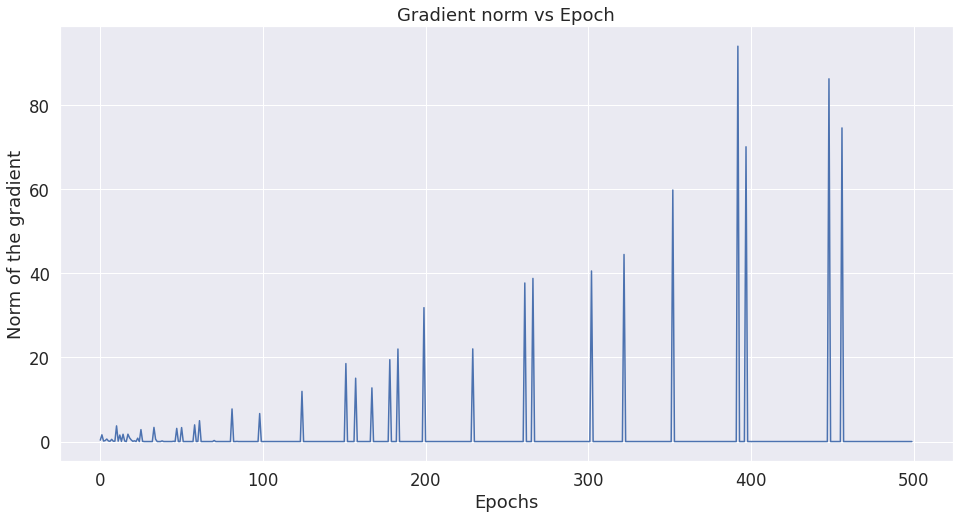

In [ ]:
fig = plt.figure(figsize = (16, 8))
sns.set(font_scale=1.5)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
sns.lineplot(x=ep, y=gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 500 epoch).pdf',dpi = 300)

In [ ]:
fig = plt.figure(figsize = (32, 16), dpi=500)
sns.set(font_scale=2.5)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
sns.scatterplot(ep,gradient_norm, s=200)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 500 epochs).pdf')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Below is the plot of gradient norm vs epoch (considering total number of epoch = 100).
In that case, the test accuracy of the model on the 10000 test images was 95.22 %.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


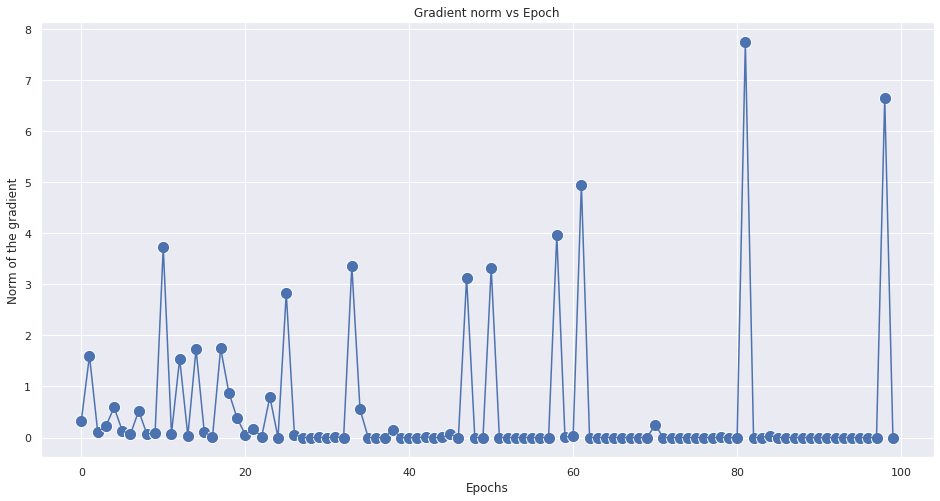

In [ ]:
fig = plt.figure(figsize = (16, 8))
sns.set(font_scale=1)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
sns.scatterplot(ep[:100],gradient_norm[:100], s=150)
sns.lineplot(ep[:100],gradient_norm[:100])
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 100 epoch).pdf')
plt.show();

In [ ]:
from google.colab import files
#files.download('scatter plot of gradient norm vs epoch (with 100 epoch).pdf')

In [ ]:
files.download('scatter plot of gradient norm vs epoch (with 500 epoch).pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gradient_norm[:100]

[0.32369816303253174,
 1.600536584854126,
 0.11754100024700165,
 0.22018079459667206,
 0.5909639596939087,
 0.1334104686975479,
 0.06307070702314377,
 0.5239003896713257,
 0.07019923627376556,
 0.08760582655668259,
 3.724024534225464,
 0.07895826548337936,
 1.5411838293075562,
 0.034421276301145554,
 1.7323293685913086,
 0.11303388327360153,
 0.0015613602008670568,
 1.7474229335784912,
 0.8816277980804443,
 0.383788138628006,
 0.055435433983802795,
 0.1704176962375641,
 0.010588337667286396,
 0.795855700969696,
 0.00026962897391058505,
 2.8323004245758057,
 0.05750501900911331,
 0.00013306662731338292,
 0.0001721287553664297,
 0.0030101831071078777,
 3.843191734631546e-05,
 0.011728791519999504,
 3.193502706722029e-08,
 3.3598108291625977,
 0.5493817329406738,
 0.00032459397334605455,
 6.91138552610937e-07,
 7.777713108225726e-06,
 0.14970020949840546,
 5.2075749408686534e-05,
 2.250978241136181e-06,
 7.101198661985109e-06,
 0.013200405985116959,
 0.00019586924463510513,
 0.00087684113

In [ ]:
!git init

Initialized empty Git repository in /content/.git/
